# Pokemon Identifier

This is going to train a pokemon identifier that will be trained on several data sources

In [1]:
import os
import sys
import string
import datetime
import shutil
import argparse
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.preprocessing.image as preprocessing 
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa
from imutils import paths #used to get the paths of all images in a dir

In [2]:
import matplotlib.pyplot as plt

## Global Values

In [3]:
clearLogs = False
strNow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ENV = "windowsLocal"

#path to dataset directory
ENV_LOG_DIR = f"../Logs/{ENV}/"
SESSION_LOG_DIR = f"../Logs/windowsLocal/{strNow}/"
CORE_DATASET = '../Datasets/Main/Images/'
TRAIN_DIR = '../Datasets/Main/Images/Train/'
VALIDATION_DIR = '../Datasets/Main/Images/Validation/'
# SAVE_DIR = os.path.join(SESSION_LOG_DIR, "Saves")
# CHECKPOINT_DIR = os.path.join(SAVE_DIR, "Checkpoints")
# FINAL_SAVE_DIR = os.path.join(SAVE_DIR, "Final")
if os.path.isdir('../Logs') is False:
    os.mkdir('../Logs')
if os.path.isdir(ENV_LOG_DIR) is False:
    os.mkdir(ENV_LOG_DIR)
if os.path.isdir(SESSION_LOG_DIR) is False: 
    os.mkdir(SESSION_LOG_DIR)

numCategories = len(os.listdir(TRAIN_DIR))

#amount of time to allot for training
trainTimeLimit = 0

#percentage of core dataset to use for training and testing
TRAIN_SPLIT = .9 

if clearLogs is True and os.path.isdir('../Logs') :
    shutil.rmtree('../Logs')
    
if os.path.isdir(CORE_DATASET) is False:
    print('DATASET NOT FOUND') 
    
if os.path.isdir(TRAIN_DIR) is False:
    print('TRAIN SET NOT FOUND')
                 
if os.path.isdir(VALIDATION_DIR) is False:
    print('VALIDATION SET NOT FOUND')

BATCH_SIZE = 32

NUM_EPOCHS = 10

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
#normalization value that will be used for color channels
IMAGE_NORM_COLOR = 255 

#should extras -- such as tensorboard be loaded for this session 
LOAD_UTILS = True

In [4]:
#tensorflow training params
NUM_NODES_IN_CONV = [128]
NUM_LAYERS_CONV = [3]

### Take command line arguments if any

In [5]:
if (len(sys.argv) > 0):
    print(sys.argv)
    listArgs = sys.argv
    for arg in listArgs: 
        splitArg = arg.split('=')
        if splitArg[0] == "timeLimit": 
            timeSplit = splitArg[1].split('.')
            if (len(timeSplit) == 3):
                hours = int(timeSplit[0])
                minutes = int(timeSplit[1])
                seconds = int(timeSplit[2])
                trainTimeLimit = (60*60*hours)+(60*minutes)+seconds
                print(f'time limit set to- {trainTimeLimit} seconds') 
        elif splitArg[0] == "epochs":
            numEpochs = int(splitArg[1])
        elif splitArg[0] == "loadextras":
            LOAD_UTILS = bool(splitArg[1])
            print('Wont load extras')
        

['/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py', '--ip=127.0.0.1', '--stdin=9026', '--control=9024', '--hb=9023', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"0a13ad97-69e3-43ff-91ee-0ae97cad2613"', '--shell=9025', '--transport="tcp"', '--iopub=9027', '--f=/tmp/tmp-258VgyYSN65ejMg.json']


In [6]:
# if (LOAD_UTILS):
#     %load_ext tensorboard
#     %tensorboard --logdir '../Logs/ubuntuLocal/fit/' --bind_all
#     %matplotlib inline

In [7]:
# parser = argparse.ArgumentParser()
# parser.add_argument('timeLimit', type=int, 

## Train

### Create Datasets with TF.Data

In [8]:
# iamgePaths = list(paths.list_images(CORE_DATASET))
# random.seed(32)
# random.shuffle(imagePaths)

# #generate training and testing split 
# i = int(len(imagePaths) * 

# datasets = [
#     ("training", trainPaths, TRAIN_DIR),
#     ("validation", validationPaths, VALIDATION_DIR)
# ]

In [9]:
# def loadDataFromDir(folder): 
#     def parseImage(imagePath):
#         #get folder structure 
#         directoryStruct = tf.strings.split(imagePath, os.path.sep)
#         classNames = np.array(trainDirectory)
#         label = directoryStruct[-2] == classNames 
        
#         img = tf.io.read_file(imagePath)

In [10]:
# def buildDataset(datasetPath: string): 
#     coreDir = None
    
#     if train is True: 
#         coreDir = TRAIN_DIR
#     else:
#         coreDir = TEST_DIR
    
#     for curDur in os.listdir(datasetPath):
#         for file in os.listdir(os.path.join(datasetPath, curDur)):
            

In [12]:
def loadImages(imagePath):
    #encode the image
    # tf.print(imagePath)
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_png(image, channels=4)
    image = tf.image.resize_with_pad(image, IMAGE_HEIGHT, IMAGE_WIDTH)
    image = tf.cast(tf.float32)
    
    #encode the label for the image
    labelParts = tf.strings.split(imagePath, os.sep)
    oneHot = labelParts[-2] == classNames 
    return (image, tf.argmax(oneHot))

In [14]:
seqAugment = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/255),
    tf.keras.layers.RandomZoom(
        height_factor=(-0.05, 0.0), #zoom in by random ammount from +20% to +30%
        width_factor=(-0.05, 0.0), 
        fill_mode='constant', 
        fill_value=0)
])

In [15]:
trainPaths = list(paths.list_images(TRAIN_DIR))
valPaths = list(paths.list_images(VALIDATION_DIR))
trainLabels = [p.split(os.path.sep)[-2] for p in trainPaths] #gather labels from dirs 
classNames = np.array(sorted(trainLabels))
classNames = np.unique(classNames)

print(len(trainPaths))

#layer used to normalize colors in datasets 
normalizationLayer = tf.keras.layers.Rescaling(1./255)

#define pipelines 
#training dataset 
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
trainDS = (trainDS
           .shuffle(len(trainPaths)) #shuffle all the images 
           .map(loadImages, num_parallel_calls=AUTOTUNE) #read images from disk 
           .map(lambda x, y: (seqAugment(x), y), num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE) #batch size
           .prefetch(AUTOTUNE)
          )

trainDS = trainDS.map(lambda x, y: (normalizationLayer(x), y))
#validation dataset
valDS = tf.data.Dataset.from_tensor_slices(valPaths)
valDS = (valDS
         .map(loadImages, num_parallel_calls=AUTOTUNE)
         .batch(BATCH_SIZE)
         .prefetch(AUTOTUNE))
valDS = valDS.map(lambda x, y: (normalizationLayer(x), y))

651949
Tensor("Equal:0", shape=(859,), dtype=bool)
Tensor("Equal:0", shape=(859,), dtype=bool)


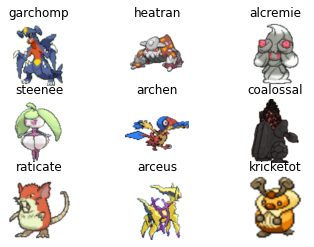

In [16]:
# # print(trainPaths[15061])
# if (LOAD_UTILS):
#   for images, labels in trainDS.take(1):
#     for i in range(9):
#       ax = plt.subplot(3, 3, i + 1)
#       plt.imshow((images[i].numpy()*255).astype("uint8"))
#       plt.title(classNames[labels[i]])
#       plt.axis("off")
#     plt.show()
    

### Create Datagenerators

In [ ]:
# train_datagen = ImageDataGenerator(rescale = 1.0/255.0, #this is to normalize colors
#                                   rotation_range=10, 
#                                   width_shift_range=0.1, 
#                                   height_shift_range=0.1,
#                                   shear_range=0.05, 
#                                   zoom_range=0.2, 
#                                   horizontal_flip = False, 
#                                   fill_mode='nearest'
#                                   )

# train_generator = train_datagen.flow_from_directory(directory=trainDirectory, 
#                                                     target_size=(150, 150), #resize image resolution
#                                                     color_mode='rgba',
#                                                     save_format='png',
#                                                     batch_size=16, 
#                                                     class_mode='sparse')

In [ ]:
# validation_datagen = ImageDataGenerator(rescale=1.0/255.0) 

# validation_generator = validation_datagen.flow_from_directory(directory=testDirectory,
#                                                               target_size=(150, 150), #resize image resolution
#                                                               color_mode='rgba',
#                                                               save_format='png',
#                                                               batch_size=16, 
#                                                               class_mode='sparse')

### Define Model

In [ ]:
for numConvLayers in NUM_LAYERS_CONV:
    for convNodes in NUM_NODES_IN_CONV:
        local_container_dir = os.path.join(SESSION_LOG_DIR, f"cl{numConvLayers}.cn{convNodes}")
        local_tensorlogs_dir = os.path.join(local_container_dir, 'fit')
        local_save_dir = os.path.join(local_container_dir, 'saves')
        local_checkpoint_dir = os.path.join(local_save_dir, 'checkpoints/')
        local_finalsave_dir = os.path.join(local_save_dir, 'final/')

        if os.path.isdir(local_container_dir) is False: 
            os.mkdir(local_container_dir)
        if os.path.isdir(local_save_dir) is False:
            os.mkdir(local_save_dir)
        if os.path.isdir(local_checkpoint_dir) is False:
            os.mkdir(local_checkpoint_dir)
        if os.path.isdir(local_finalsave_dir) is False: 
            os.mkdir(local_finalsave_dir)

        #write summary to file 
        infoFile = os.path.join(local_container_dir, "into.txt")
        with open(infoFile, 'w') as file: 
            file.write(f"Number of convolution layers: {numConvLayers} \r")
            file.write(f"Number of nodes per convolution layer: {convNodes} \r")
            file.write(f"Input size expected: {IMAGE_WIDTH}, {IMAGE_HEIGHT}\r")
            file.write(f"Epochs: {NUM_EPOCHS}\r")
            file.write(f"Max ammount of rotation: {}")
            file.close()

        #cleanup from last round 
        tf.keras.backend.clear_session()

        #define the model 
        model = tf.keras.models.Sequential()
        for i in range(numConvLayers):
            model.add(tf.keras.layers.Conv2D(int(convNodes), (3,3)))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Activation('relu'))
            model.add(tf.keras.layers.MaxPool2D((2,2)))

        #flatten out 
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dense(len(classNames), activation='softmax'))
        
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
        
        #create callbacks as necessary
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=local_checkpoint_dir, 
                                                                save_weights_only=True, 
                                                                verbose=1)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=local_tensorlogs_dir,                        
                                                            histogram_freq=1, 
                                                            write_graph=True, 
                                                            write_images=False, 
                                                            embeddings_freq=1, 
                                                            profile_batch='1,5')
            
        time_stopping_callback = None
        history = None
        
        if (trainTimeLimit != 0):
            #shorten the time limit to allow for post training data processing
            trainTimeLimit = trainTimeLimit - (60*5) 
            time_stopping_callback = tfa.callbacks.TimeStopping(seconds=TrainTimeLimit, verbose=1)
            history = model.fit(trainDS, 
                                epochs=1, 
                                validation_data=valDS,
                                callbacks=[tensorboard_callback, checkpoint_callback, time_stopping_callback])
        else:
            #no time limit callback
            history = model.fit(trainDS, 
                        epochs=NUM_EPOCHS, 
                        validation_data=valDS,
                        callbacks=[tensorboard_callback, checkpoint_callback])

        #save model and record completion in info file
        model.save(local_finalsave_dir)
        with open(infoFile, 'a') as file: 
            file.write('Training Complete')
            file.close()

SyntaxError: invalid syntax (<ipython-input-1-78972bbfe1e8>, line 38)

#### Zip Logs For Download

In [ ]:
shutil.make_archive('Logs', 'zip', '../Logs')

'/workspaces/Tensorflow/Class/AdvancedAI/PokemonIdentifier/Src/Logs.zip'